In [ ]:
#https://stackoverflow.com/questions/69822304/google-colab-google-drive-can%c2%b4t-be-mounted-anymore-browser-popup-google-dri
!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.com%2Foauth2callback&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&

In [ ]:
!sudo apt-get install -qq w3m # to act as web browser
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package w3m.
(Reading database ... 120900 files and directories currently installed.)
Preparing to unpack .../w3m_0.5.3+git20210102-6ubuntu0.1_amd64.deb ...
Unpacking w3m (0.5.3+git20210102-6ubuntu0.1) ...
Setting up w3m (0.5.3+git20210102-6ubuntu0.1) ...
Processing triggers for man-db (2.10.2-1) ...
/content
/content/drive
/content
/
Access token retrieved correctly.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
shutil.copy("/content/drive/MyDrive/mlcvnets.rar", "/content")

'/content/mlcvnets.rar'

In [ ]:
!pip install rarfile

In [ ]:
import os
import rarfile
os.chdir("/content/")

with rarfile.RarFile("mlcvnets.rar", "r") as z_fp:
    z_fp.extractall("/content/mlcvnets")
os.makedirs("/content/mlcvnets/datasets")

In [ ]:
import os
import keras
import tarfile

url = "http://trax-geometry.s3.amazonaws.com/cvpr_challenge/SKU110K_fixed.tar.gz"
filename = os.path.join(os.getcwd(), "data.tar.gz")
keras.utils.get_file(filename, url)

with tarfile.open("data.tar.gz", "r") as z_fp:
    z_fp.extractall("/content/")

12196152718/12196152718 [==============================] - 225s 0us/step


In [ ]:
os.makedirs("/content/SKU110K_fixed/classes")
shutil.copy("/content/drive/MyDrive/SKU_fixed_classes/classes/class_mappings.csv",
            "/content/SKU110K_fixed/classes")

'/content/SKU110K_fixed/classes/class_mappings.csv'

In [ ]:
import os
os.chdir("/content/mlcvnets/main_work")

In [ ]:
import os
import sys

import csv
import cv2
import torch

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from torchvision.io import read_image
from six import raise_from
from tqdm import tqdm

from get_image_size import get_image_size
from engine import train_one_epoch, evaluate

import utils_vision
import transforms as T
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

sys.path.insert(0, "/content/mlcvnets")
from data import create_train_val_loader
from options.utils import load_config_file
from options.opts import get_training_arguments

from cvnets import get_model
from cvnets.models.detection import build_detection_model
from cvnets.models.classification import arguments_classification, build_classification_model

In [ ]:
import sys
sys.argv=['']
del sys
os.getcwd()

'/content/mlcvnets/main_work'

In [ ]:
from torch import nn, Tensor
from typing import Callable, Dict, List, Optional, Union

from torchvision.ops.feature_pyramid_network import ExtraFPNBlock, FeaturePyramidNetwork, LastLevelMaxPool
from torchvision.models._utils import handle_legacy_interface, IntermediateLayerGetter
class BackboneWithFPN(nn.Module):
    def __init__(
        self,
        backbone: nn.Module,
        return_layers: Dict[str, str],
        in_channels_list: List[int],
        out_channels: int,
        extra_blocks: Optional[ExtraFPNBlock] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()

        if extra_blocks is None:
            extra_blocks = LastLevelMaxPool()

        self.body = IntermediateLayerGetter(backbone, return_layers=return_layers)
        self.fpn = FeaturePyramidNetwork(
            in_channels_list=in_channels_list,
            out_channels=out_channels,
            extra_blocks=extra_blocks,
            norm_layer=norm_layer,
        )
        self.out_channels = out_channels

    def forward(self, x: Tensor) -> Dict[str, Tensor]:
        x = self.body(x)
        x = self.fpn(x)
        return x

In [ ]:
from torch import nn
from typing import Callable, Dict, List, Optional, Union
from torchvision.ops.feature_pyramid_network import ExtraFPNBlock, FeaturePyramidNetwork, LastLevelMaxPool


def _mobilevit_fpn_extractor(
    backbone,
    trainable_layers: int,
    returned_layers: Optional[List[int]] = None,
    extra_blocks: Optional[ExtraFPNBlock] = None,
    norm_layer: Optional[Callable[..., nn.Module]] = None,
):

    layers_to_train = ["conv_1x1_exp", "layer_5", "layer_4", "layer_3", "layer_2", "layer_1", "conv_1"][:trainable_layers]
    for name, parameter in backbone.named_modules():
        if all([not name.startswith(layer) for layer in layers_to_train]):
            parameter.requires_grad_(False)
    if extra_blocks is None:
        extra_blocks = LastLevelMaxPool()
    if returned_layers is None:
        returned_layers = [1,2,3,4,5]
    if min(returned_layers)<=0 or max(returned_layers)>=6:
        raise ValueError(f"Each returned layer should be in the range [1,5]. Got {returned_layers}")
    return_layers = {f"layer_{k}": str(v) for v,k in enumerate(returned_layers)}
    in_channels_list = []
    for layer in layers_to_train[::-1]:
        if layer.split('_')[0] == 'layer':
            in_channels_list.append(getattr(backbone, layer)[0].out_channels)
        else: in_channels_list.append(getattr(backbone, layer).out_channels)
    in_channels_list = in_channels_list[:-1]
    in_channels_list = in_channels_list[len(returned_layers)-1:]
    out_channels=256
    print("in_channels_list: ", in_channels_list)
    print("====> Done !")
    return BackboneWithFPN(backbone=backbone, return_layers=return_layers, in_channels_list=in_channels_list, out_channels=out_channels, extra_blocks=extra_blocks, norm_layer=norm_layer)


In [ ]:
opts = get_training_arguments()
setattr(opts, "common.config_file", "config/detection/ssd_mobilevitv3_xx_small_320.yaml")
opts = load_config_file(opts=opts)

setattr(opts, "model.detection.n_classes", 81)
setattr(opts, "dataset.workers", 0)

mobilevit = build_classification_model(opts=opts)

backbone = _mobilevit_fpn_extractor(backbone=mobilevit, trainable_layers=6, returned_layers=[3,4,5])

2023-09-28 11:46:56 - LOGS    - Pretrained weights are loaded from /content/mlcvnets/results/mobilevitv3_xx_small_e300_7098/run_1/checkpoint_ema_best.pt
in_channels_list:  [64, 80, 128]
====> Done !


In [ ]:
backbone.eval()

BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False, normalization=SyncBatchNorm, activation=Swish, bias=False)
    (layer_1): Sequential(
      (0): InvertedResidual(in_channels=16, out_channels=16, stride=1, exp=2, dilation=1)
    )
    (layer_2): Sequential(
      (0): InvertedResidual(in_channels=16, out_channels=24, stride=2, exp=2, dilation=1)
      (1): InvertedResidual(in_channels=24, out_channels=24, stride=1, exp=2, dilation=1)
      (2): InvertedResidual(in_channels=24, out_channels=24, stride=1, exp=2, dilation=1)
    )
    (layer_3): Sequential(
      (0): InvertedResidual(in_channels=24, out_channels=64, stride=2, exp=2, dilation=1)
      (1): MobileViTv3Block(
      	conv_in_dim=64, conv_out_dim=64, dilation=1, conv_ksize=3
      	patch_h=2, patch_w=2
      	transformer_in_dim=64, transformer_n_heads=4, transformer_ffn_dim=128, dropout=0.05, ffn_dropout=0.0, attn_dropout=0.0, blocks

In [ ]:
img_demo = torch.rand(1,3,320,320)

In [ ]:
backbone(img_demo)

OrderedDict([('0',
              tensor([[[[-0.5565, -1.8976, -1.9223,  ..., -2.0160, -1.8038, -1.1865],
                        [-0.2269, -1.1441, -1.6283,  ..., -1.5145, -1.3102, -0.4472],
                        [-0.4284, -1.2288, -1.4528,  ..., -1.4002, -1.3916, -0.2329],
                        ...,
                        [ 0.0036, -0.7052, -0.7373,  ..., -0.6952, -0.8970, -0.2242],
                        [ 0.3126, -0.4876, -0.6948,  ..., -0.5738, -0.7494, -0.1713],
                        [-0.1753, -0.3654, -0.4458,  ..., -0.3507, -0.2200,  0.3834]],
              
                       [[-0.4599, -0.4592, -0.2428,  ..., -0.5383, -0.6272,  0.3701],
                        [ 0.3026,  0.5286,  0.4004,  ...,  0.3561,  0.0724,  0.7852],
                        [ 0.2595,  0.3321,  0.6231,  ...,  0.4502,  0.1986,  0.6598],
                        ...,
                        [ 0.2878,  0.4459,  0.5544,  ...,  0.2800,  0.1482,  0.7661],
                        [ 0.5028,  0.5659,  0.4

In [ ]:
from torchvision.models.detection.anchor_utils import AnchorGenerator
def _default_anchorgen():
    anchor_sizes = tuple((x, int(x * 2 ** (1.0 / 3)), int(x * 2 ** (2.0 / 3))) for x in [8,16,32,64])
    aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
    anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)
    return anchor_generator

In [ ]:
from torchvision.models.detection import RetinaNet

num_classes = 2
anchor_generator = _default_anchorgen()
model = RetinaNet(backbone=backbone, num_classes=num_classes, anchor_generator=anchor_generator)

In [ ]:
model

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False, normalization=SyncBatchNorm, activation=Swish, bias=False)
      (layer_1): Sequential(
        (0): InvertedResidual(in_channels=16, out_channels=16, stride=1, exp=2, dilation=1)
      )
      (layer_2): Sequential(
        (0): InvertedResidual(in_channels=16, out_channels=24, stride=2, exp=2, dilation=1)
        (1): InvertedResidual(in_channels=24, out_channels=24, stride=1, exp=2, dilation=1)
        (2): InvertedResidual(in_channels=24, out_channels=24, stride=1, exp=2, dilation=1)
      )
      (layer_3): Sequential(
        (0): InvertedResidual(in_channels=24, out_channels=64, stride=2, exp=2, dilation=1)
        (1): MobileViTv3Block(
        	conv_in_dim=64, conv_out_dim=64, dilation=1, conv_ksize=3
        	patch_h=2, patch_w=2
        	transformer_in_dim=64, transformer_n_heads=4, transformer_ffn_dim=128

In [ ]:
#model.eval()
#model(img_demo)

In [ ]:
def _parse(value, function, fmt):
    try:
        return function(value)
    except ValueError as e:
        raise_from(ValueError(fmt.format(e)), None)
def _open_for_csv(path):
    return open(path, 'r', newline='')
def get_image_metadata(file_path):
    size = os.path.getsize(file_path)
def _read_classes(csv_reader):
    result = {}
    for line, row in enumerate(csv_reader):
        line += 1
        try:
            class_name, class_id = row
        except ValueError:
            raise_from(ValueError(
                'line {}: format should be \'class_name,class_id\''.format(line)), None)
        class_id = _parse(
            class_id, int, 'line {}: malformed class ID: {{}}'.format(line))

        if class_name in result:
            raise ValueError(
                'line {}: duplicate class name: \'{}\''.format(line, class_name))
        result[class_name] = class_id
        return result
def _read_images(base_dir):
    result = {}
    #dirs = [os.path.join(base_dir, o) for o in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, o))]
    dirs = [os.path.join(base_dir, 'images')]
    if len(dirs) == 0:
        dirs = ['']
    for project in dirs:
        project_imgs = os.listdir(os.path.join(base_dir, project))
        i = 0
        print("Loading images...")
        for image in tqdm(project_imgs):
            try:
                img_file = os.path.join(base_dir, project, image)
                exists = os.path.isfile(img_file)

                if not exists:
                    print("Warning: Image file {} is not existing".format(img_file))
                    continue
                # Image shape
                height, width = get_image_size(img_file)
                result[img_file] = {"width": width, "height": height}
                i += 1
            except Exception as e:
                print("Error: {} in image: {}".format(str(e), img_file))
                continue
    return result
def _read_annotations(csv_reader, classes, base_dir, image_existence):
    result = {}
    base_dir = os.path.join(base_dir, 'images')
    for line, row in enumerate(csv_reader):
        line += 1
        try:
            img_file, x1, y1, x2, y2, class_name, width, height = row[:]
            x1 = int(x1)
            x2 = int(x2)
            y1 = int(y1)
            y2 = int(y2)
            width = int(width)
            height = int(height)
            if x1 >= width:
                x1 = width - 1
            if x2 >= width:
                x2 = width - 1

            if y1 >= height:
                y1 = height - 1
            if y2 >= height:
                y2 = height - 1
            # x1 < 0 | y1 < 0 | x2 <= 0 | y2 <= 0
            if x1<0 | y1<0 or x2<=0 or y2<=0:
                print("Warning: Image file {} has some bad boxes annotations".format(img_file))
                continue
            # Append root path
            img_file = os.path.join(base_dir, img_file)
            # Check images exists
            if img_file not in image_existence:
                print("Warning: Image file {} is not existing".format(img_file))
                continue
        except ValueError:
            raise_from(ValueError(
                'line {}: format should be \'img_file,x1,y1,x2,y2,class_name\' or \'img_file,,,,,\''.format(line)),
                None)
        if img_file not in result:
            result[img_file] = []
        # If a row contains only an image path, it's an image without annotations.
        if (x1,x2,y1,y2,class_name) == ('', '', '', '', ''):
            continue
        x1 = _parse(x1, int, 'line {}: malformed x1: {{}}'.format(line))
        y1 = _parse(y1, int, 'line {}: malformed y1: {{}}'.format(line))
        x2 = _parse(x2, int, 'line {}: malformed x2: {{}}'.format(line))
        y2 = _parse(y2, int, 'line {}: malformed y2: {{}}'.format(line))
        # Check that the bounding box is valid.
        if x2 <= x1:
            raise ValueError('line {}: x2 ({}) must be higher than x1 ({})'.format(line, x2, x1))
        if y2 <= y1:
            raise ValueError('line {}: y2 ({}) must be higher than y1 ({})'.format(line, y2, y1))
        # check if the current class name is correctly present
        if class_name not in classes:
            raise ValueError('line {}: unknown class name: \'{}\' (classes: {})'.format(line, class_name, classes))
        result[img_file].append({'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2, 'class': class_name})
    return result

In [ ]:
def plot_img_bbox(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height = box[0], box[1], abs(box[2]-box[0]), abs(box[3]-box[1])
        rect = patches.Rectangle((x,y), width, height,
                                 linewidth=2, edgecolor = 'r', facecolor='none')
        a.add_patch(rect)
    plt.show()

def plot_img(img):
    fig, ax = plt.subplots(1,1)
    ax.imshow(img)
    plt.show()


In [ ]:
class CSVGenerator(torch.utils.data.Dataset):
    def __init__(self, csv_data_file, csv_class_file, width, height, base_dir=None, transform = None, **kwargs):
        self.image_names = []
        self.image_data = {}
        self.base_dir = base_dir
        self.transform = transform
        self.height = height
        self.width = width

        # __ delete __
        self.csv_data_file = csv_data_file
        self.csv_class_file = csv_class_file
        # __ delete __

        # Take base_dir from annotations file if not explicitly specified.
        if self.base_dir is None:
            self.base_dir = os.path.dirname(os.path.dirname(csv_data_file))

        # Parse the provided class file
        try:
            with _open_for_csv(csv_class_file) as file:
                self.classes = _read_classes(csv.reader(file, delimiter=','))
                # classes['object] = 0
        except ValueError as e:
            raise_from(ValueError(
                'invalid CSV class file: {}: {}'.format(csv_class_file, e)), None)

        self.labels = {}
        for key, value in self.classes.items():
            self.labels[value] = key  # labels[1] = object

        # build mappings for existence
        self.image_existence = _read_images(self.base_dir)

        # csv with img_path, x1, y1, x2, y2, class_name
        try:
            with _open_for_csv(csv_data_file) as file:
                self.image_data = _read_annotations(csv.reader(file, delimiter=','), self.classes, self.base_dir, self.image_existence)
        except ValueError as e:
            raise_from(ValueError('invalid CSV annotations file: {}: {}'.format(csv_data_file, e)), None)
        self.image_names = list(self.image_data.keys())

    def __getitem__(self, index):
        img_name = image_path = self.image_names[index]
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        img_res = img_res/255.0
        boxes = []
        labels = []
        wt = img.shape[1]
        ht = img.shape[0]
        for row in self.image_data.get(img_name):
            #{'x1': 208, 'x2': 422, 'y1': 537, 'y2': 814, 'class': 'object'}
            x1, x2, y1, y2, class_name = row['x1'], row['x2'], row['y1'], row['y2'], row['class']
            labels.append(self.classes.get(class_name))
            xmin_corr = (x1/wt)*self.width
            xmax_corr = (x2/wt)*self.width
            ymin_corr = (y1/ht)*self.height
            ymax_corr = (y2/ht)*self.height
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:,3]-boxes[:,1])*(boxes[:,2]-boxes[:,0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.as_tensor([index])
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = image_id
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transform is not None:
            sample = self.transform(image = img_res, bboxes = target['boxes'], labels = labels)
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
        return img_res, target

    def __len__(self):
        return len(self.image_names)



In [ ]:
train_generator = CSVGenerator(
    csv_data_file= os.path.abspath("../../SKU110K_fixed/annotations/annotations_train.csv"),
    csv_class_file= os.path.abspath("../../SKU110K_fixed/classes/class_mappings.csv"),
    width=2048,
    height=2048
)


Loading images...


100%|██████████| 11743/11743 [00:20<00:00, 571.08it/s]


In [ ]:
print('length of dataset = {}'.format(len(train_generator)))

length of dataset = 8219


In [ ]:
img, target = train_generator[78]
print('length of dataset = {}'.format(len(train_generator)))
#print(img.shape, '\n', target)

length of dataset = 8219


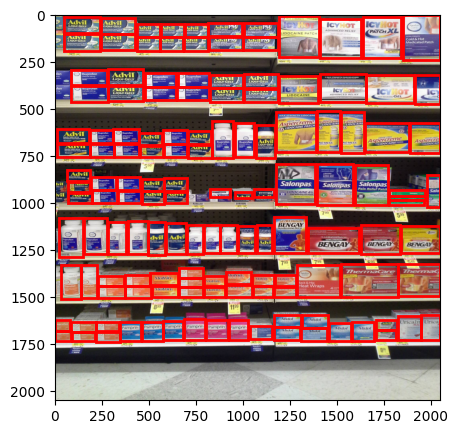

In [ ]:
img, target = train_generator[100]
plot_img_bbox(img, target)

In [ ]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
dataset = CSVGenerator(
    csv_data_file= os.path.abspath("../../SKU110K_fixed/annotations/annotations_train.csv"),
    csv_class_file= os.path.abspath("../../SKU110K_fixed/classes/class_mappings.csv"),
    width=2048,
    height=2048,
    transform=get_transform(train=True)
)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, #num_workers=0,
    collate_fn=utils_vision.collate_fn)

Loading images...


100%|██████████| 11743/11743 [00:01<00:00, 7645.36it/s]


In [ ]:
images, targets = next(iter(dataloader))
images = list(image for image in images)
targets = [{k:v for k,v in t.items()} for t in targets]

In [ ]:
model(images, targets)

{'classification': tensor(1.1570, grad_fn=<DivBackward0>),
 'bbox_regression': tensor(1.1929, grad_fn=<DivBackward0>)}

In [ ]:
from torchvision.models.detection.retinanet import retinanet_resnet50_fpn

retina = retinanet_resnet50_fpn(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:00<00:00, 260MB/s]


In [ ]:
retina(images, targets)

{'classification': tensor(1.3188, grad_fn=<DivBackward0>),
 'bbox_regression': tensor(0.4810, grad_fn=<DivBackward0>)}

In [ ]:
dataset = CSVGenerator(
    csv_data_file= os.path.abspath("../../SKU110K_fixed/annotations/annotations_train.csv"),
    csv_class_file= os.path.abspath("../../SKU110K_fixed/classes/class_mappings.csv"),
    width=2048,
    height=2048,
    transform=get_transform(train=True)
)
dataset_test = CSVGenerator(
    csv_data_file= os.path.abspath("../../SKU110K_fixed/annotations/annotations_train.csv"),
    csv_class_file= os.path.abspath("../../SKU110K_fixed/classes/class_mappings.csv"),
    width=2048,
    height=2048,
    transform=get_transform(train=False)
)

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=0,
    collate_fn=utils_vision.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=5, shuffle=False, num_workers=0,
    collate_fn=utils_vision.collate_fn)

Loading images...


100%|██████████| 11743/11743 [00:01<00:00, 8628.48it/s]


Loading images...


100%|██████████| 11743/11743 [00:00<00:00, 25242.70it/s]


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#torch.cuda.set_per_process_memory_fraction(0.9)
#torch.cuda.empty_cache()

In [ ]:
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.0005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
num_epochs = 1
for epoch in range(num_epochs):
    train_one_epoch(model=model, optimizer=optimizer, data_loader=data_loader, device=device, epoch=epoch, print_freq=10)
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/658]  eta: 2:26:04  lr: 0.000001  loss: 2.0034 (2.0034)  classification: 1.1296 (1.1296)  bbox_regression: 0.8738 (0.8738)  time: 13.3199  data: 3.8630  max mem: 8476
Epoch: [0]  [ 10/658]  eta: 0:57:08  lr: 0.000009  loss: 1.9356 (1.9440)  classification: 1.1296 (1.1296)  bbox_regression: 0.8061 (0.8144)  time: 5.2913  data: 3.3729  max mem: 8530
Epoch: [0]  [ 20/658]  eta: 0:51:57  lr: 0.000016  loss: 1.9281 (1.9468)  classification: 1.1295 (1.1295)  bbox_regression: 0.7985 (0.8172)  time: 4.4647  data: 3.2933  max mem: 8530
Epoch: [0]  [ 30/658]  eta: 0:49:30  lr: 0.000024  loss: 1.9208 (1.9489)  classification: 1.1295 (1.1295)  bbox_regression: 0.7913 (0.8194)  time: 4.4217  data: 3.2334  max mem: 8531
Epoch: [0]  [ 40/658]  eta: 0:47:18  lr: 0.000032  loss: 1.9218 (1.9449)  classification: 1.1295 (1.1295)  bbox_regression: 0.7924 (0.8153)  time: 4.2855  data: 3.0913  max mem: 8531
Epoch: [0]  [ 50/658]  eta: 0:46:08  lr: 0.000039  loss: 1.9275 (1.9424)  classifica

In [ ]:
PATH = "/content/drive/MyDrive/Checkpoints/checkpoint_mobile_vit_28_09.pt"
torch.save(model.state_dict(), PATH)

In [ ]:
from torchvision import transforms as torchtrans

def apply_nms(orig_prediction, iou_thresh=0.1):
    # torchvision returns the indices of the bboxes to" keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)

    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [ ]:
# pick one image from the test set
img, target = dataset_test[50]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]

print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  300
real #boxes:  118


EXPECTED OUTPUT


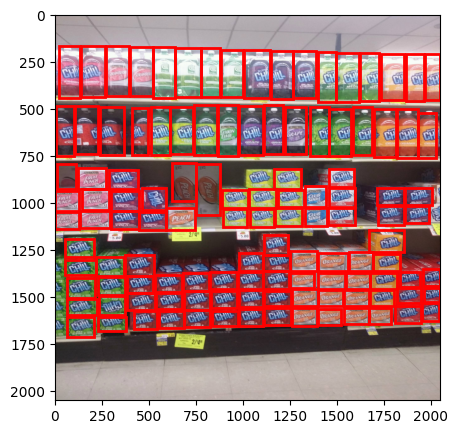

In [ ]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

MODEL OUTPUT


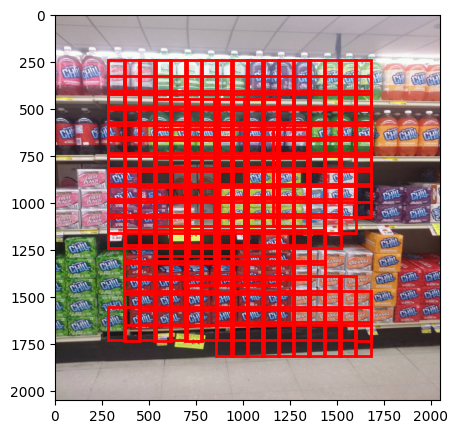

In [ ]:
for x,y in prediction.items():
  prediction[x] = y.cpu()
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)

In [ ]:
from google.colab import drive
drive.flush_and_unmount()